<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

# Gift Xipu: 220123773

### Time Series Analysis of Daily Steps Data

</div>


<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Data Preparation

Importing Required Libraries
</div>

In [109]:
import pandas as pd
import numpy as np
import glob as gl
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import pandas.io.formats.style as style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Load and Combine Data Files

</div>

In [89]:
path = "data/"
all_files = gl.glob(os.path.join(path, "*.csv"))
df_list = []
for file in all_files:
    try:
        temp_df = pd.read_csv(file)
        df_list.append(temp_df)
    except Exception as e:
        print(f"Error loading {file}: {e}")
df = pd.concat(df_list, ignore_index=True)

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Data Cleaning and Preprocessing

</div>

In [90]:
if 'Actual' in df.columns:
    df = df.rename(columns={'Actual': 'Steps'})
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
invalid_dates = df['Date'].isna().sum()
if invalid_dates > 0:
    print(f"Found {invalid_dates} invalid dates - removing these rows")
    df = df.dropna(subset=['Date'])

In [91]:
df = df[(df['Steps'] >= 0) & (df['Steps'] <= 50000)]
missing_before = df['Steps'].isna().sum()
if missing_before > 0:
    print(f"Handling {missing_before} missing values using forward fill")
    df['Steps'] = df['Steps'].fillna(method='ffill')
    remaining_missing = df['Steps'].isna().sum()
    if remaining_missing > 0:
        df['Steps'] = df['Steps'].fillna(method='bfill')
        print(f"Used backward fill for {remaining_missing} remaining missing values")

In [92]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep='first')]
print("\nDescriptive statistics:")
stats_table = df['Steps'].describe().reset_index()
stats_table.columns = ["Statistic", "Value"]
display(HTML(stats_table.to_html(index=False)))


Descriptive statistics:


Statistic,Value
count,420.000000
mean,5674.140476
std,2930.565439
min,0.000000
25%,3634.000000
50%,5402.000000
75%,7349.000000
max,16611.000000


<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## 2. Exploratory Data Analysis (EDA)
Time Series Visualization

</div>

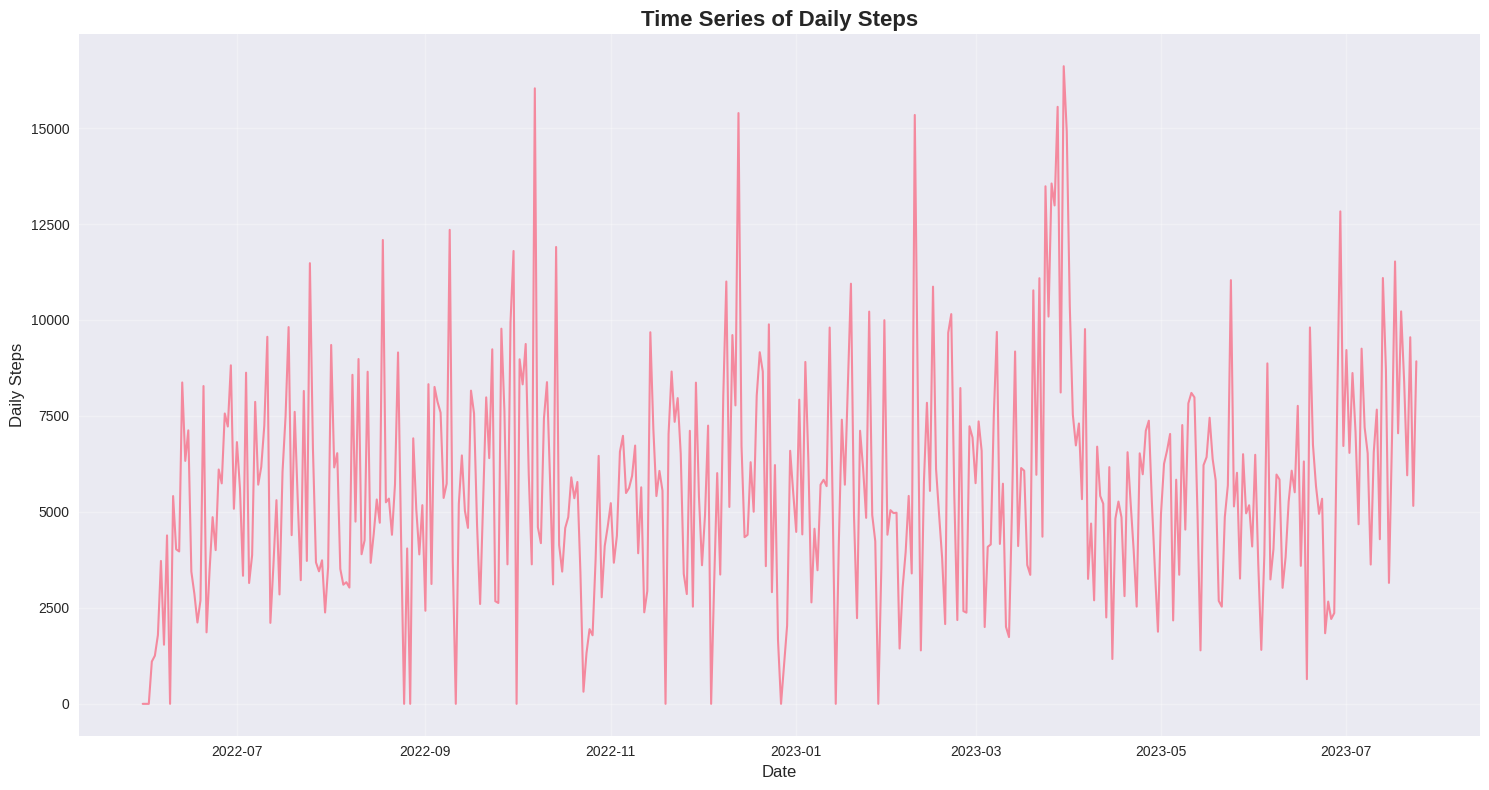

In [93]:
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Steps'], linewidth=1.5, alpha=0.8)
plt.title('Time Series of Daily Steps', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Steps', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Descriptive Statistics

</div>

In [94]:
stats = df['Steps'].describe().reset_index()
stats.columns = ["Statistic", "Value"]
extra_stats = pd.DataFrame({
    "Statistic": ["Skewness", "Kurtosis", "Coefficient of Variation"],
    "Value": [
        round(df['Steps'].skew(), 3),
        round(df['Steps'].kurtosis(), 3),
        round(df['Steps'].std() / df['Steps'].mean(), 3)
    ]
})
full_stats = pd.concat([stats, extra_stats], ignore_index=True)
display(HTML(full_stats.to_html(index=False)))

Statistic,Value
count,420.000000
mean,5674.140476
std,2930.565439
min,0.000000
25%,3634.000000
50%,5402.000000
75%,7349.000000
max,16611.000000
Skewness,0.676000
Kurtosis,1.025000


<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Distrubution Analysis

</div>

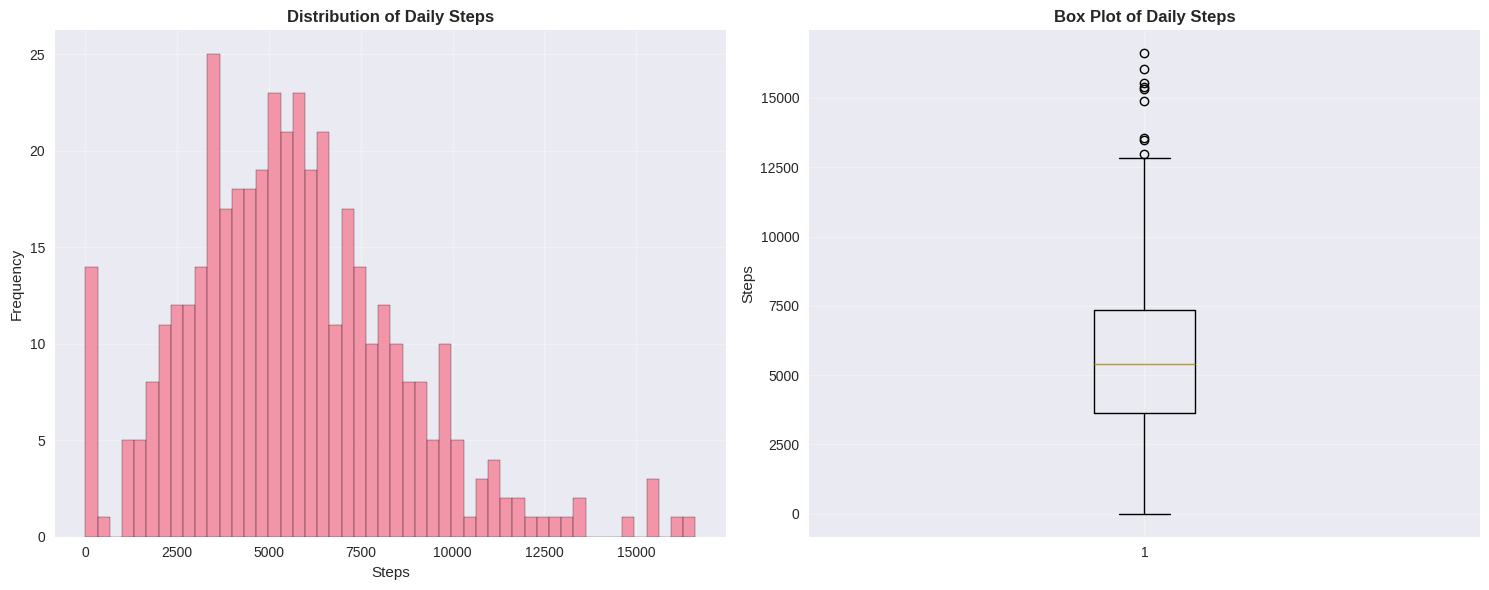

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(df['Steps'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Daily Steps', fontweight='bold')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)
axes[1].boxplot(df['Steps'])
axes[1].set_title('Box Plot of Daily Steps', fontweight='bold')
axes[1].set_ylabel('Steps')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Rolling Statistics Analysis

</div>

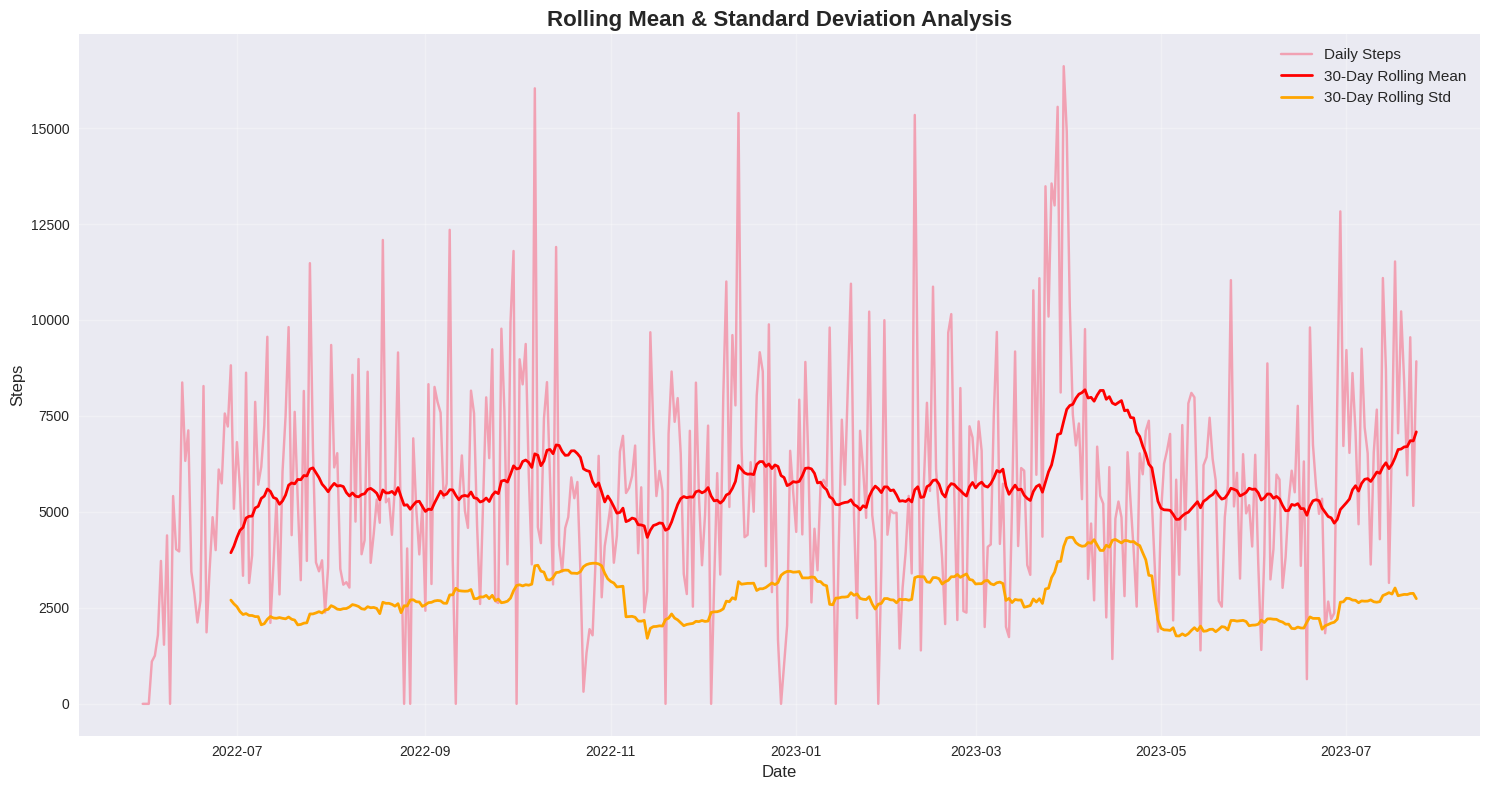

Rolling mean statistics (window=30 days):
Average rolling mean: 5709.98
Rolling mean trend: 1953.64


In [96]:
window_size = 30
rolling_mean = df['Steps'].rolling(window=window_size).mean()
rolling_std = df['Steps'].rolling(window=window_size).std()
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Steps'], label='Daily Steps', alpha=0.6)
plt.plot(rolling_mean.index, rolling_mean, color='red', label=f'{window_size}-Day Rolling Mean', linewidth=2)
plt.plot(rolling_std.index, rolling_std, color='orange', label=f'{window_size}-Day Rolling Std', linewidth=2)
plt.title('Rolling Mean & Standard Deviation Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Steps', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Rolling mean statistics (window={window_size} days):")
print(f"Average rolling mean: {rolling_mean.mean():.2f}")
print(f"Rolling mean trend: {rolling_mean.iloc[-30:].mean() - rolling_mean.iloc[:30].mean():.2f}")

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## 3. Seasonality and Stationarity Testing
Seasonal Decomposition

</div>

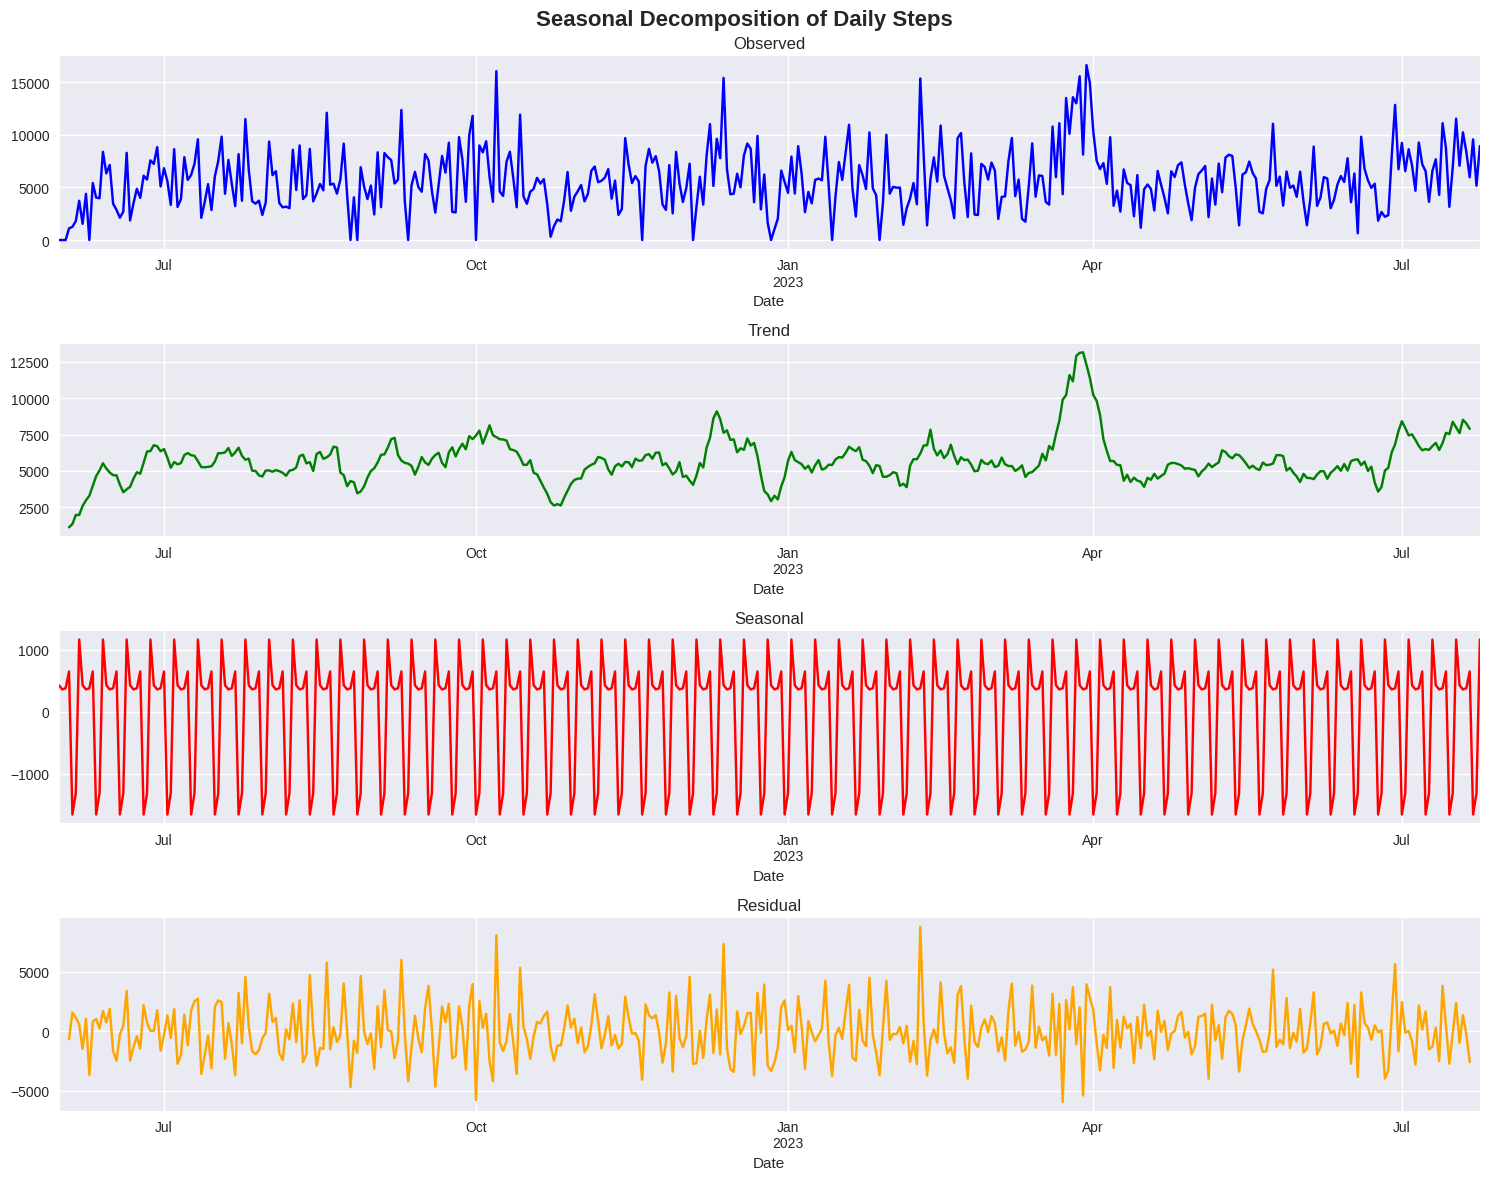

Seasonal component analysis:
Monday: 425.57
Tuesday: 357.65
Wednesday: 376.99
Thursday: 646.39
Friday: -1655.24
Saturday: -1311.36
Sunday: 1160.01


In [98]:
decomposition = seasonal_decompose(df['Steps'], model='additive', period=7)
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Observed', color='blue')
decomposition.trend.plot(ax=axes[1], title='Trend', color='green')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='red')
decomposition.resid.plot(ax=axes[3], title='Residual', color='orange')
plt.suptitle('Seasonal Decomposition of Daily Steps', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Seasonal component analysis:")
seasonal_pattern = decomposition.seasonal.iloc[:7]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, day in enumerate(days):
    print(f"{day}: {seasonal_pattern.iloc[i]:.2f}")

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Stationarity Testing

</div>

In [100]:
result = adfuller(df['Steps'].dropna())
adf_results = pd.DataFrame({
    'Metric': ['ADF Statistic', 'p-value'] + list(result[4].keys()),
    'Value': [result[0], result[1]] + list(result[4].values())
})
print("\nStationarity Test Results for Original Steps Series:")
display(HTML(adf_results.to_html(index=False)))
is_stationary = result[1] <= 0.05
status = "STATIONARY" if is_stationary else "NOT STATIONARY"
interpretation = "Reject null hypothesis - series is stationary" if is_stationary else "Fail to reject null hypothesis - series has unit root"
summary = pd.DataFrame({
    'Result': [status],
    'Interpretation': [interpretation],
    'Conclusion': [f"Data is {'stationary' if is_stationary else 'non-stationary'}"]
})
display(HTML(summary.to_html(index=False)))
if not is_stationary:
    print("\nTesting First Difference for Stationarity...")
    df['Steps_diff'] = df['Steps'].diff()
    result_diff = adfuller(df['Steps_diff'].dropna())
    adf_results_diff = pd.DataFrame({
        'Metric': ['ADF Statistic', 'p-value'] + list(result_diff[4].keys()),
        'Value': [result_diff[0], result_diff[1]] + list(result_diff[4].values())
    })
    print("\nStationarity Test Results for First Differenced Series:")
    display(HTML(adf_results_diff.to_html(index=False)))
    is_stationary_diff = result_diff[1] <= 0.05
    status_diff = "STATIONARY" if is_stationary_diff else "NOT STATIONARY"
    interpretation_diff = "Reject null hypothesis - series is stationary" if is_stationary_diff else "Fail to reject null hypothesis - series has unit root"
    summary_diff = pd.DataFrame({
        'Result': [status_diff],
        'Interpretation': [interpretation_diff],
        'Conclusion': [f"Data is {'stationary' if is_stationary_diff else 'non-stationary'}"]
    })
    display(HTML(summary_diff.to_html(index=False)))


Stationarity Test Results for Original Steps Series:


Metric,Value
ADF Statistic,-4.831054
p-value,0.000047
1%,-3.446560
5%,-2.868685
10%,-2.570576


Result,Interpretation,Conclusion
STATIONARY,Reject null hypothesis - series is stationary,Data is stationary


<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## 4. Model Selection and Parameter Estimation
Train-Test Split

</div>

Training data: 2022-05-31 00:00:00 to 2023-06-24 00:00:00
Training samples: 390
Test data: 2023-06-25 00:00:00 to 2023-07-24 00:00:00
Test samples: 30


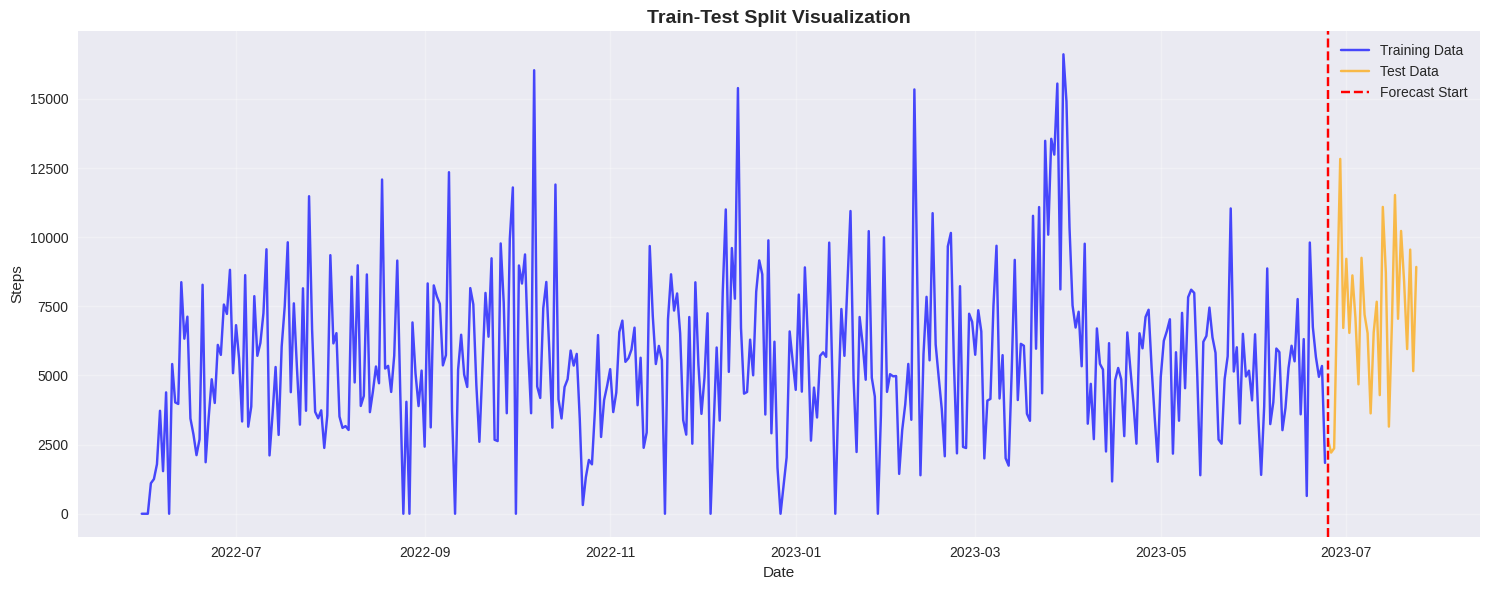

In [101]:
forecast_start = pd.to_datetime('2023-06-25')
train = df.loc[:forecast_start - pd.Timedelta(days=1), 'Steps']
test = df.loc[forecast_start:, 'Steps']
print(f"Training data: {train.index.min()} to {train.index.max()}")
print(f"Training samples: {len(train)}")
print(f"Test data: {test.index.min()} to {test.index.max()}")
print(f"Test samples: {len(test)}")
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', color='blue', alpha=0.7)
plt.plot(test.index, test, label='Test Data', color='orange', alpha=0.7)
plt.axvline(x=forecast_start, color='red', linestyle='--', label='Forecast Start')
plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## ARIMA Model

</div>

In [62]:
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fitted = arima_model.fit()
model_info = pd.DataFrame({
    'Parameter': ['Model Order', 'Log Likelihood', 'AIC', 'BIC', 'Sample Size'],
    'Value': [
        str(arima_model.order),
        round(arima_fitted.llf, 2),
        round(arima_fitted.aic, 2),
        round(arima_fitted.bic, 2),
        len(train)
    ]
})
print("\nARIMA Model Information:")
display(HTML(model_info.to_html(index=False)))
arima_forecast = arima_fitted.forecast(steps=len(test))
arima_forecast = pd.Series(arima_forecast, index=test.index)
forecast_summary = pd.DataFrame({
    'Metric': ['Forecast Period', 'Min Forecast', 'Max Forecast', 'Mean Forecast', 'Forecast Std'],
    'Value': [
        f"{len(test)} days",
        round(arima_forecast.min(), 0),
        round(arima_forecast.max(), 0),
        round(arima_forecast.mean(), 0),
        round(arima_forecast.std(), 0)
    ]
})
print("\nForecast Summary:")
display(HTML(forecast_summary.to_html(index=False)))


ARIMA Model Information:


Parameter,Value
Model Order,"(5, 1, 0)"
Log Likelihood,-3653.7
AIC,7319.39
BIC,7343.17
Sample Size,390



Forecast Summary:


Metric,Value
Forecast Period,30 days
Min Forecast,4216.0
Max Forecast,5462.0
Mean Forecast,4679.0
Forecast Std,189.0


<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Prophet Model

</div>

In [102]:
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Steps': 'y'})
train_prophet = df_prophet[df_prophet['ds'] < forecast_start]
test_prophet = df_prophet[df_prophet['ds'] >= forecast_start]
prep_summary = pd.DataFrame({
    'Dataset': ['Prophet Training', 'Prophet Test', 'Total'],
    'Samples': [len(train_prophet), len(test_prophet), len(df_prophet)],
    'Percentage': [
        f"{len(train_prophet)/len(df_prophet)*100:.1f}%", 
        f"{len(test_prophet)/len(df_prophet)*100:.1f}%", 
        "100.0%"
    ]
})
print("\nData Preparation Summary:")
display(HTML(prep_summary.to_html(index=False)))
prophet_model = Prophet(
    daily_seasonality=False,  
    weekly_seasonality=True,  
    yearly_seasonality=True,  
    seasonality_mode='additive'
)

print("\nFitting Prophet model...")
prophet_model.fit(train_prophet)
prophet_config = pd.DataFrame({
    'Setting': ['Daily Seasonality', 'Weekly Seasonality', 'Yearly Seasonality', 'Seasonality Mode', 'Growth'],
    'Value': ['Disabled', 'Enabled', 'Enabled', 'Additive', 'Linear']
})
print("\nProphet Model Configuration:")
display(HTML(prophet_config.to_html(index=False)))
future = prophet_model.make_future_dataframe(periods=len(test))
prophet_forecast_full = prophet_model.predict(future)
prophet_forecast = prophet_forecast_full.set_index('ds').loc[forecast_start:, 'yhat']
prophet_summary = pd.DataFrame({
    'Metric': ['Forecast Period', 'Min Forecast', 'Max Forecast', 'Mean Forecast', 'Forecast Std'],
    'Value': [
        f"{len(test)} days",
        round(prophet_forecast.min(), 0),
        round(prophet_forecast.max(), 0), 
        round(prophet_forecast.mean(), 0),
        round(prophet_forecast.std(), 0)
    ]
})
print("\nForecast Summary:")
display(HTML(prophet_summary.to_html(index=False)))


Data Preparation Summary:


Dataset,Samples,Percentage
Prophet Training,390,92.9%
Prophet Test,30,7.1%
Total,420,100.0%


16:19:58 - cmdstanpy - INFO - Chain [1] start processing
16:19:58 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet model...

Prophet Model Configuration:


Setting,Value
Daily Seasonality,Disabled
Weekly Seasonality,Enabled
Yearly Seasonality,Enabled
Seasonality Mode,Additive
Growth,Linear



Forecast Summary:


Metric,Value
Forecast Period,30 days
Min Forecast,5456.0
Max Forecast,9538.0
Mean Forecast,7715.0
Forecast Std,1136.0


<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## 5. Forecasting and Model Comparison
ARIMA Forecast Visualization

</div>

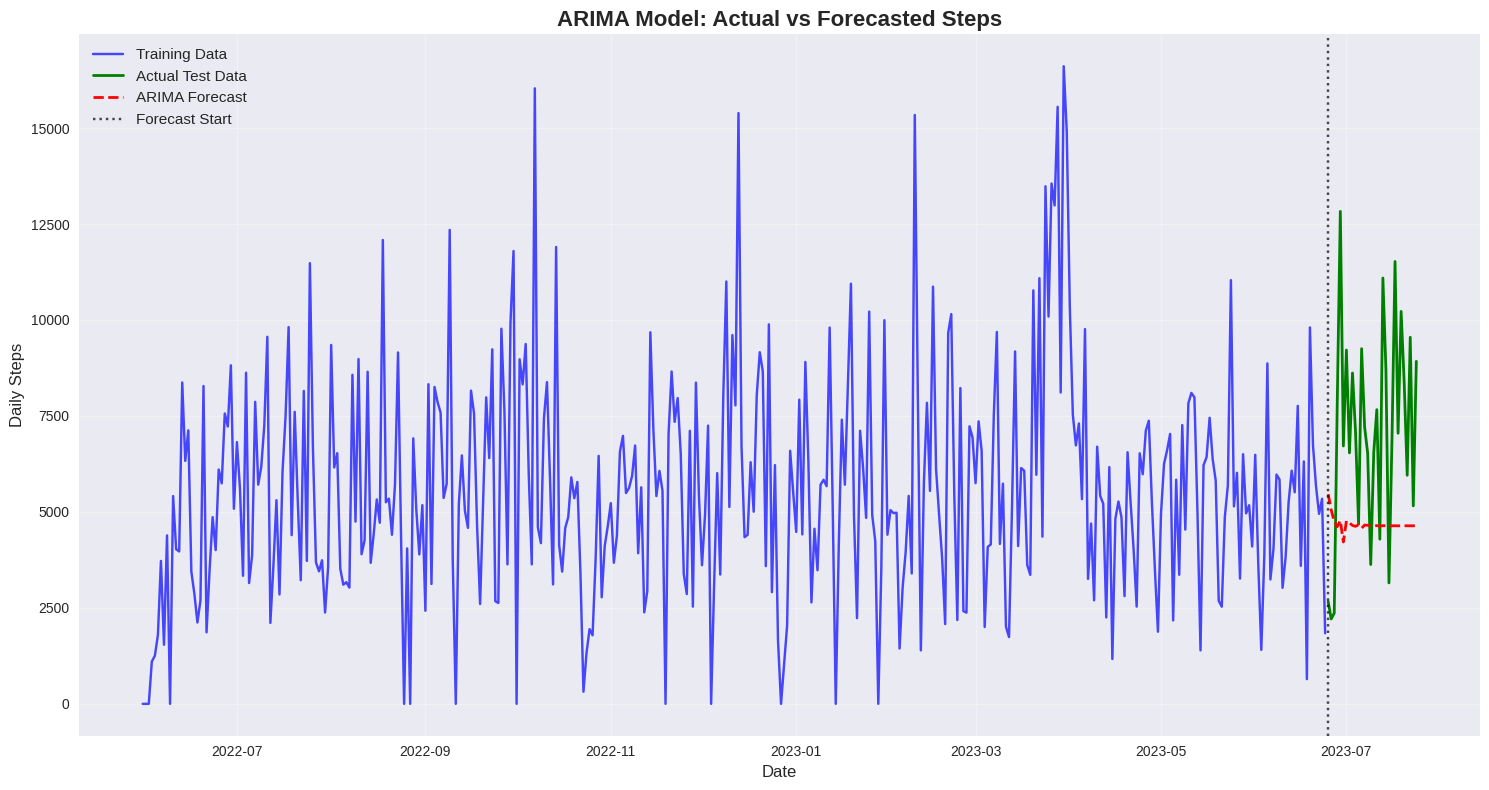

In [103]:
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label='Training Data', color='blue', alpha=0.7)
plt.plot(test.index, test, label='Actual Test Data', color='green', linewidth=2)
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='red', linewidth=2, linestyle='--')
plt.axvline(x=forecast_start, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
plt.title('ARIMA Model: Actual vs Forecasted Steps', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Steps', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Prophet Forecast Visualization

</div>

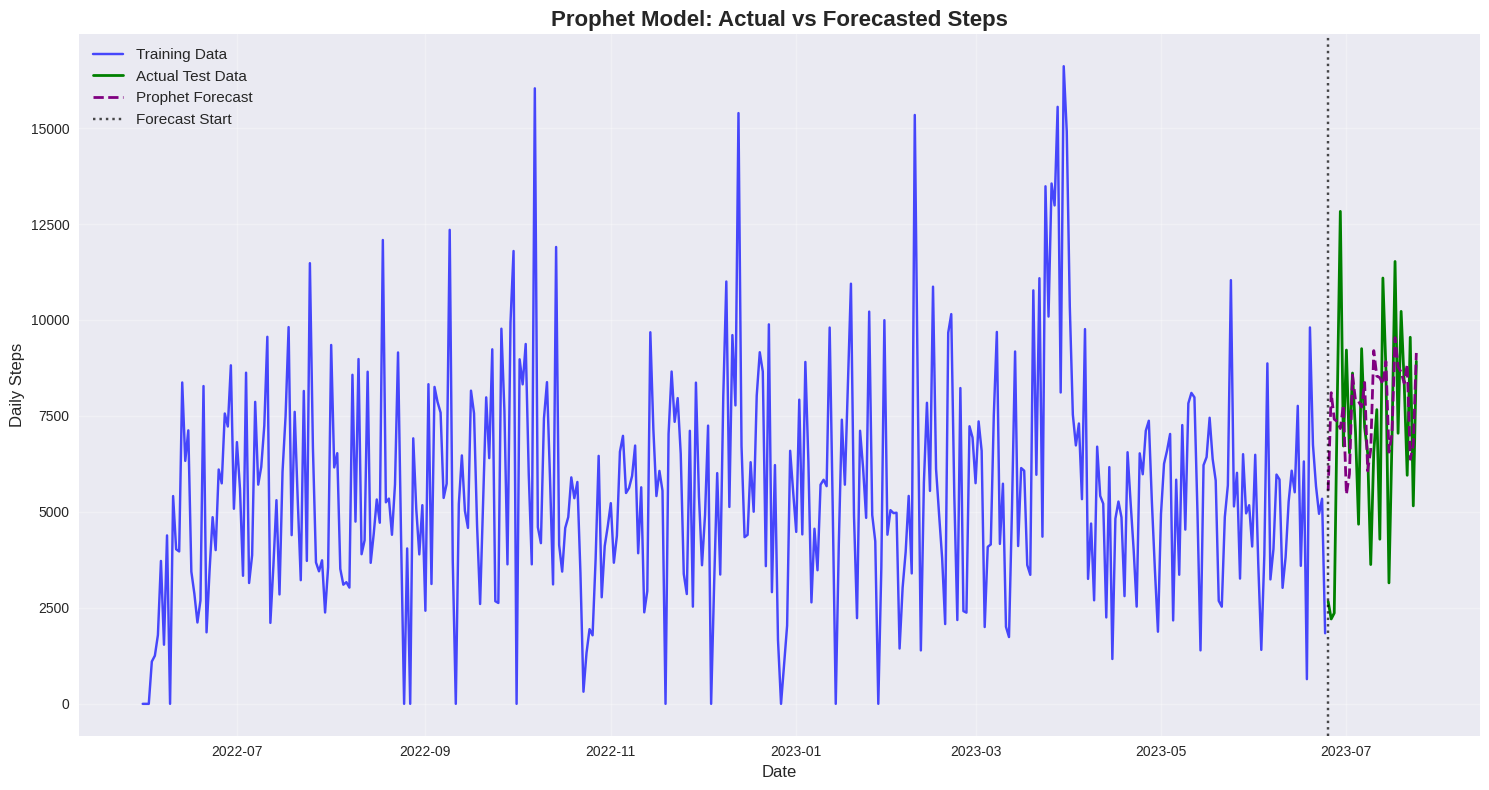

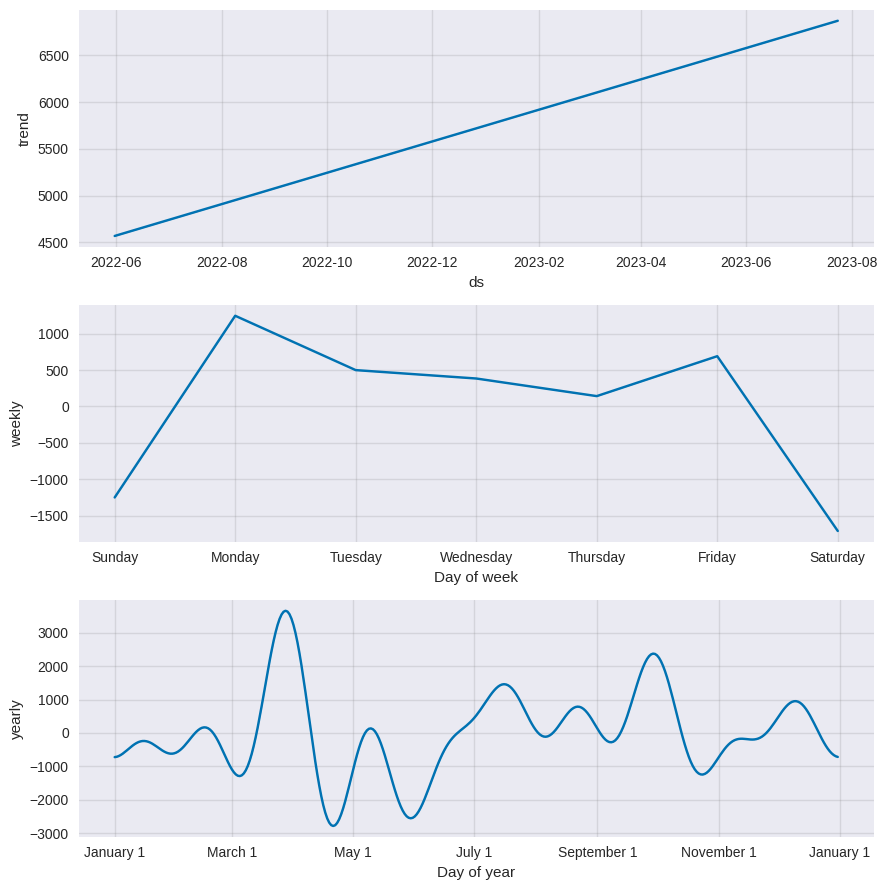

In [104]:
plt.figure(figsize=(15, 8))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Training Data', color='blue', alpha=0.7)
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='green', linewidth=2)
plt.plot(prophet_forecast.index, prophet_forecast, label='Prophet Forecast', color='purple', linewidth=2, linestyle='--')
plt.axvline(x=forecast_start, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
plt.title('Prophet Model: Actual vs Forecasted Steps', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Steps', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig = prophet_model.plot_components(prophet_forecast_full)
plt.show()

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Combined Model Comparison

</div>

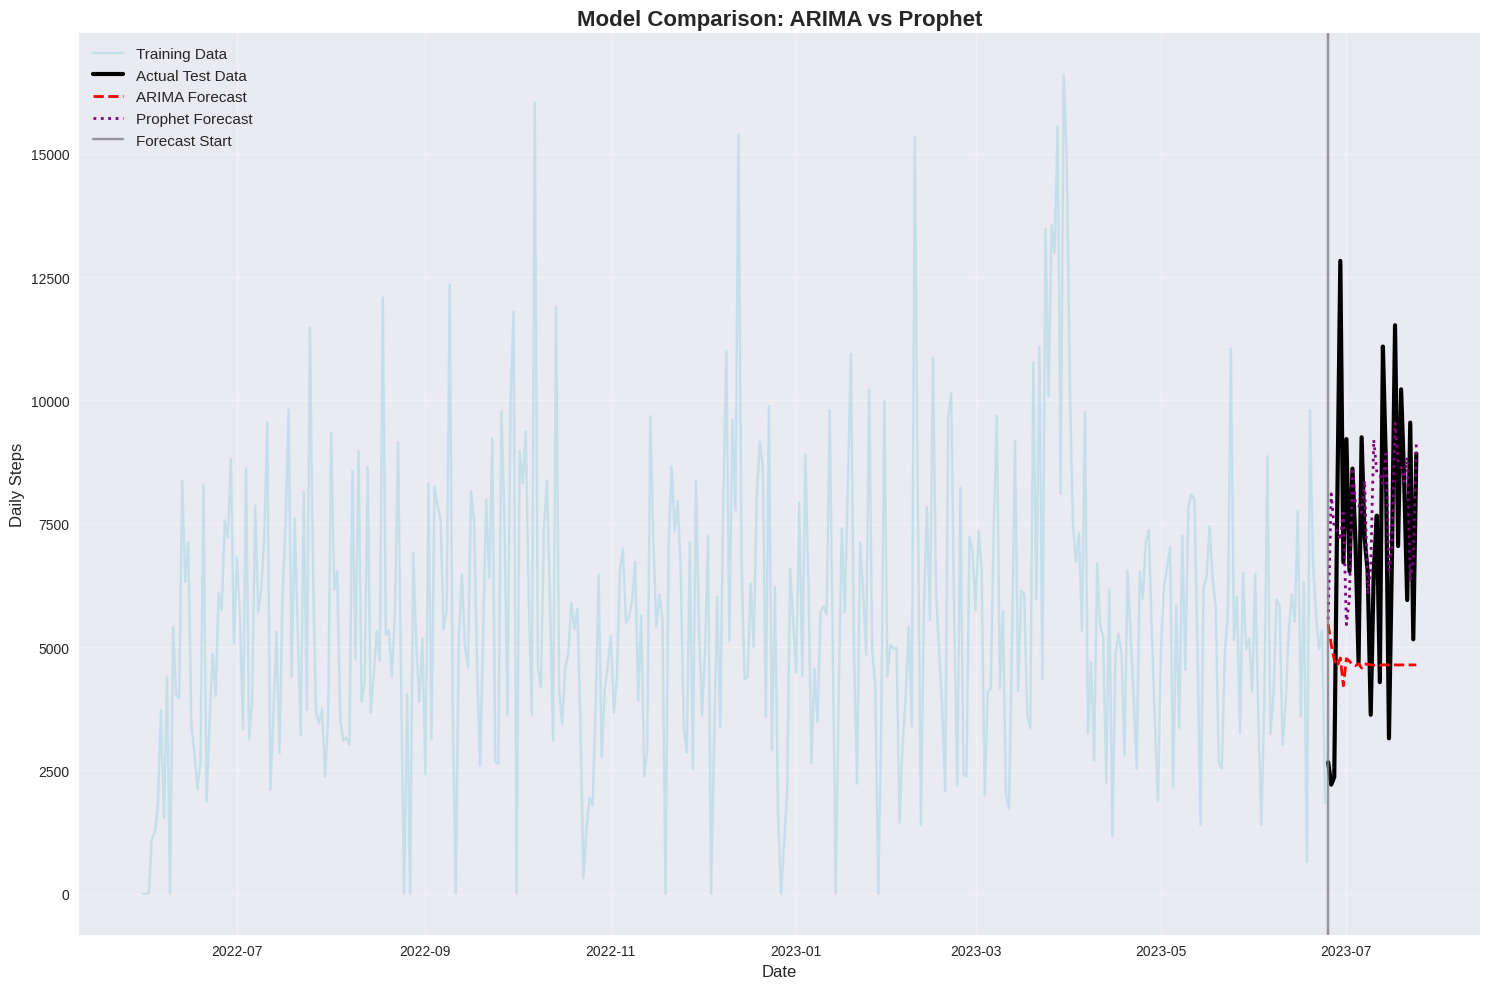

In [105]:
plt.figure(figsize=(15, 10))
plt.plot(train.index, train, label='Training Data', color='lightblue', alpha=0.6)
plt.plot(test.index, test, label='Actual Test Data', color='black', linewidth=3)
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='red', linewidth=2, linestyle='--')
plt.plot(prophet_forecast.index, prophet_forecast, label='Prophet Forecast', color='purple', linewidth=2, linestyle=':')
plt.axvline(x=forecast_start, color='gray', linestyle='-', alpha=0.8, label='Forecast Start')
plt.title('Model Comparison: ARIMA vs Prophet', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Steps', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="background-color:#F5F5F5; padding:20px; border-radius:10px">

## Model Performance Metrics

</div>

In [106]:
def calculate_metrics(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }
    print(f"\n{model_name} Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}" if k != 'MAPE' else f"{k}: {v:.2f}%")
    
    return metrics
    
arima_metrics = calculate_metrics(test, arima_forecast, "ARIMA")
prophet_metrics = calculate_metrics(test_prophet['y'], prophet_forecast, "Prophet")
metrics_comparison = pd.DataFrame({
    'ARIMA': [arima_metrics['MSE'], arima_metrics['RMSE'], arima_metrics['MAE'], arima_metrics['R²']],
    'Prophet': [prophet_metrics['MSE'], prophet_metrics['RMSE'], prophet_metrics['MAE'], prophet_metrics['R²']]
}, index=['MSE', 'RMSE', 'MAE', 'R²'])
display(HTML(metrics_comparison.round(4).to_html()))
best_model = "ARIMA" if arima_metrics['RMSE'] < prophet_metrics['RMSE'] else "Prophet"
best_rmse = min(arima_metrics['RMSE'], prophet_metrics['RMSE'])
print(f"\n{best_model} model performs better with lower RMSE ({best_rmse:.2f})")


ARIMA Performance Metrics:
MSE: 13424906.3609
RMSE: 3664.0014
MAE: 3130.2322
R²: -0.8500
MAPE: 45.40%

Prophet Performance Metrics:
MSE: 7186617.7003
RMSE: 2680.7868
MAE: 2103.7414
R²: 0.0096
MAPE: nan%


,ARIMA,Prophet
MSE,1.342491e+07,7.186618e+06
RMSE,3.664001e+03,2.680787e+03
MAE,3.130232e+03,2.103741e+03
R²,-8.500000e-01,9.600000e-03



Prophet model performs better with lower RMSE (2680.79)


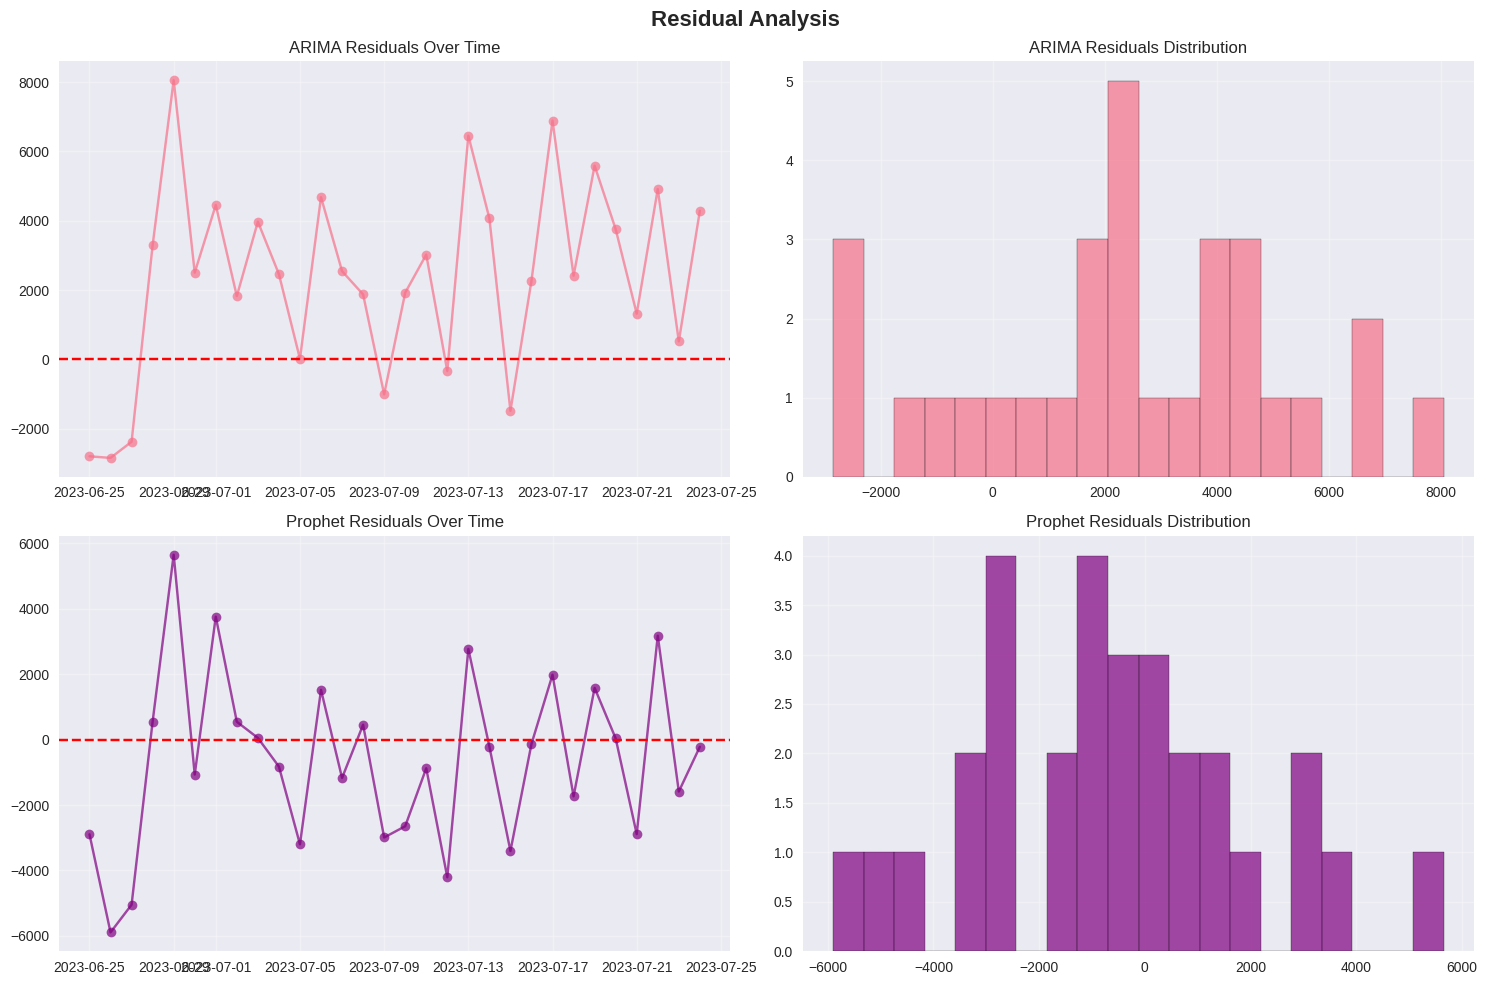

ARIMA residuals - Mean: 2406.50, Std: 2810.14
Prophet residuals - Mean: -629.52, Std: 2605.82


In [107]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
arima_residuals = test - arima_forecast
axes[0,0].plot(arima_residuals.index, arima_residuals, 'o-', alpha=0.7)
axes[0,0].set_title('ARIMA Residuals Over Time')
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].grid(True, alpha=0.3)
axes[0,1].hist(arima_residuals, bins=20, alpha=0.7, edgecolor='black')
axes[0,1].set_title('ARIMA Residuals Distribution')
axes[0,1].grid(True, alpha=0.3)
prophet_residuals = test_prophet['y'].values - prophet_forecast.values
axes[1,0].plot(test.index, prophet_residuals, 'o-', alpha=0.7, color='purple')
axes[1,0].set_title('Prophet Residuals Over Time')
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].grid(True, alpha=0.3)
axes[1,1].hist(prophet_residuals, bins=20, alpha=0.7, edgecolor='black', color='purple')
axes[1,1].set_title('Prophet Residuals Distribution')
axes[1,1].grid(True, alpha=0.3)
plt.suptitle('Residual Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print(f"ARIMA residuals - Mean: {arima_residuals.mean():.2f}, Std: {arima_residuals.std():.2f}")
print(f"Prophet residuals - Mean: {np.mean(prophet_residuals):.2f}, Std: {np.std(prophet_residuals):.2f}")

<div style="background-color:#f9f9f9; padding:20px; border-radius:10px; border:1px solid #ddd">

### 6. Reflection and Conclusions

**Decision-Making Process**  
I used ARIMA (5,1,0) because it works well for simple univariate time series. I also tried Prophet because it handles seasonality and missing data more easily.

**What I Learned**  
The data shows clear weekly patterns and long-term trends in activity, with noticeable day-to-day variability. Cleaning the data and handling missing values or outliers made a big difference in model performance. ARIMA captured the autocorrelation in the series, while Prophet picked up the seasonal patterns more directly.

**Tools and Methods**  
I processed the data with Pandas, visualized it with Matplotlib and Seaborn, and used the Augmented Dickey-Fuller test to check stationarity. I applied ARIMA and Prophet for forecasting and evaluated the results using MSE, RMSE, MAE, and R².

**Next Steps**  
I want to try automated parameter selection, include extra factors like weather or events, explore more advanced models like SARIMA or LSTM, and experiment with feature engineering and cross-validation. I also plan to handle outliers more systematically.

**Summary**  
Both ARIMA and Prophet gave reasonable forecasts, showing general trends and patterns. Using both models helped me understand the data better and gave a good foundation for improving future predictions.

</div>
